
# Baseline Experiment 1

Train model from scratch for each subject. 

Model: BSFShallowNet

Dataset: BCI Competitin IV 2a, BCNI2014001 via MOABB library


In [1]:
import matplotlib.pyplot as plt
from braindecode.datasets import MOABBDataset
from numpy import multiply
from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os
import pickle
from matplotlib.lines import Line2D
# from braindecode.visualization import plot_confusion_matrix

from braindecode.datasets import BaseConcatDataset
from braindecode.datasets.base import EEGWindowsDataset
from braindecode.preprocessing.windowers import _create_windows_from_events
import numpy as np
import mne
import random

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


## Loading and preparing the data




### Loading the dataset




In [2]:
subject_id = 3
# dataset_name = "Lee2019_MI"
# dataset_name = 'BNCI2014_009'
dataset_name = 'Schirrmeister2017'
# dataset = MOABBDataset(dataset_name=dataset_name, subject_ids=list(range(1, 10)))
dataset = MOABBDataset(dataset_name=dataset_name, subject_ids=[subject_id,])

Extracting EDF parameters from C:\Users\mengz\mne_data\MNE-schirrmeister2017-data\robintibor\high-gamma-dataset\raw\master\data\train\3.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').
Channel 'EEG FC6' recognized as type EEG (renamed to 'FC6').
Channel 'EEG M1' recognized as type EEG (renamed to 'M1').
Channel 'EEG T7' recognized as type EEG (renamed to 'T7').

### Preprocessing




In [3]:
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


### Extracting Compute Windows




In [4]:
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    # window_size_samples=400,
    # window_stride_samples=400,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'rest', 'right_hand']
Used Annotations descriptions: ['feet', 'left_hand', 'rest', 'right_hand']


In [76]:
def generate_non_repeating_integers(x, y):
    # Check if y is greater than x
    if y < x:
        raise ValueError("y must be greater than or equal to x")
    
    # Generate x non-repeating integers between 0 and y
    return random.sample(range(y), x)

def sample_integers_sum_to_x(x, k):
    '''
    k >= 2
    '''
    # Generate k-1 random integers between 1 and x
    parts = sorted(random.randint(1, x) for _ in range(k-1))
    
    # Calculate the differences between consecutive numbers
    differences = [parts[0]] + [parts[i] - parts[i-1] for i in range(1, k-1)] + [x - parts[-1]]
    
    return differences

def get_subset(input_set, target_trial_num, random_sample=False):
    # check inputs
    assert isinstance(input_set, BaseConcatDataset)
    assert isinstance(target_trial_num, int)
    
    new_ds_lst = []

    if random_sample:
        
        base_ds_cnt = len(input_set.datasets)

        if base_ds_cnt == 1:
            cur_ds = input_set.datasets[0]
            trial_idx = generate_non_repeating_integers(target_trial_num, len(cur_ds))
            print(trial_idx[:4])
            new_ds_lst.append(EEGWindowsDataset(cur_ds.raw, cur_ds.metadata.iloc[trial_idx], 
                                                        description=cur_ds.description))

        elif base_ds_cnt > 1:
            trial_cnt_from_each_base_ds = sample_integers_sum_to_x(target_trial_num, base_ds_cnt)
            for i, cnt in enumerate(trial_cnt_from_each_base_ds):
                if not cnt:
                    # no sampling in current base dataset
                    continue
            
                # Access current base dataset
                cur_ds = input_set.datasets[i]
                assert isinstance(cur_ds, EEGWindowsDataset)
                # Randomly sample trial index
                try:
                    trial_idx = generate_non_repeating_integers(cnt, len(cur_ds))
                    new_ds_lst.append(EEGWindowsDataset(cur_ds.raw, cur_ds.metadata.iloc[trial_idx], 
                                                        description=cur_ds.description))
                except ValueError:
                    # If trying to sample more trials in current ds than there are
                    # Get entire cur_ds, and get what's missing fromt the next ds
                    new_ds_lst.append(cur_ds)
                    trial_cnt_from_each_base_ds[i+1] += (cnt - len(cur_ds))

    else:
    
        for ds in input_set.datasets:
            assert isinstance(ds, EEGWindowsDataset)
            cur_run_trial_num = len(ds.metadata)
            if target_trial_num > cur_run_trial_num:
                new_ds_lst.append(ds)
                target_trial_num -= cur_run_trial_num
            else:
                new_ds_lst.append(EEGWindowsDataset(ds.raw, ds.metadata[:target_trial_num], description=ds.description))
                break

    return BaseConcatDataset(new_ds_lst)

## Creating a model




In [63]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
# n_classes = 2
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_chans = windows_dataset[0][0].shape[0]
input_window_samples = windows_dataset[0][0].shape[1]

## Model Training




In [64]:
windows_dataset.get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,session,run
0,0,1251,3501,0,3,0,0train
1,0,4751,7001,1,3,0,0train
2,0,8686,10936,2,3,0,0train
3,0,12581,14831,3,3,0,0train
4,0,16416,18666,3,3,0,0train
...,...,...,...,...,...,...,...
155,0,587686,589936,1,3,0,1test
156,0,591356,593606,2,3,0,1test
157,0,594861,597111,0,3,0,1test
158,0,598691,600941,3,3,0,1test


In [77]:
# valid_set_size = 1
data_amount_step = 20
repetition = 3

dict_results = {}

for subj_id, subj_dataset in windows_dataset.split('subject').items():

    dict_subj_results = {}

    ### Split by train and test sessions
    splitted_by_run = subj_dataset.split('run')
    subj_train_set = splitted_by_run.get('0train')
    subj_valid_set = splitted_by_run.get('1test')

    ### Use the last "valid_set_size" number of sets for testing
    # splitted_lst_by_run = list(subj_dataset.split('run').values())
    # subj_train_set = BaseConcatDataset(splitted_lst_by_run[:-valid_set_size])
    # subj_valid_set = BaseConcatDataset(splitted_lst_by_run[-valid_set_size:])

    # splitted_by_run = subj_dataset.split('session')
    # subj_train_set = BaseConcatDataset(splitted_lst_by_run[:-valid_set_size])
    # subj_train_set = splitted_by_run.get('0')
    # subj_valid_set = BaseConcatDataset(splitted_lst_by_run[-valid_set_size:])
    # subj_valid_set = splitted_by_run.get('1')
    
    train_trials_num = len(subj_train_set.get_metadata())

    for training_data_amount in np.arange(1, train_trials_num // data_amount_step) * data_amount_step:
    
        for i in range(repetition):

            # cur_model = ShallowFBCSPNet(
            #     n_chans,
            #     n_classes,
            #     input_window_samples=input_window_samples,
            #     final_conv_length='auto',
            # )
            
            # lr = 0.0625 * 0.01
            # weight_decay = 0
            # # batch_size = 64
            # batch_size = int(min(training_data_amount // 2, 64))
            # n_epochs = 40
        
            # # Re-initialize EEGClassifier
            # cur_clf = EEGClassifier(
            #     cur_model,
            #     criterion=torch.nn.NLLLoss,
            #     optimizer=torch.optim.AdamW,
            #     train_split=predefined_split(subj_valid_set),  # using valid_set for validation
            #     optimizer__lr=lr,
            #     optimizer__weight_decay=weight_decay,
            #     batch_size=batch_size,
            #     callbacks=[
            #         "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
            #     ],
            #     device=device,
            #     classes=classes,
            # )
        
            # Get current training set
            # print(training_data_amount)
            cur_train_set = get_subset(subj_train_set, int(training_data_amount), random_sample=True)
        
            # Fit model
            print(f'Training model for subject {subj_id} with {training_data_amount} = {len(cur_train_set)} trials (repetition {i})')
            # _ = cur_clf.fit(cur_train_set, y=None, epochs=n_epochs)
        
            # results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
            # results_columns = ['valid_accuracy',]
            # df = pd.DataFrame(cur_clf.history[:, results_columns], columns=results_columns,
            #                   index=cur_clf.history[:, 'epoch'])
            
            # get percent of misclass for better visual comparison to loss
            # df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
            #                valid_misclass=100 - 100 * df.valid_accuracy)
        
            # cur_final_acc = np.mean(df.tail(5).valid_accuracy)
            # dict_subj_results.update({training_data_amount: cur_final_acc})

        # dict_results.update({subj_id: dict_subj_results})

[201, 295, 599, 420]
Training model for subject 3 with 20 = 20 trials (repetition 0)
[556, 482, 841, 261]
Training model for subject 3 with 20 = 20 trials (repetition 1)
[236, 495, 309, 445]
Training model for subject 3 with 20 = 20 trials (repetition 2)
[246, 358, 26, 90]
Training model for subject 3 with 40 = 40 trials (repetition 0)
[112, 575, 812, 657]
Training model for subject 3 with 40 = 40 trials (repetition 1)
[590, 271, 867, 307]
Training model for subject 3 with 40 = 40 trials (repetition 2)
[73, 414, 544, 507]
Training model for subject 3 with 60 = 60 trials (repetition 0)
[91, 255, 380, 29]
Training model for subject 3 with 60 = 60 trials (repetition 1)
[655, 105, 278, 402]
Training model for subject 3 with 60 = 60 trials (repetition 2)
[445, 821, 807, 695]
Training model for subject 3 with 80 = 80 trials (repetition 0)
[411, 605, 498, 341]
Training model for subject 3 with 80 = 80 trials (repetition 1)
[800, 839, 326, 770]
Training model for subject 3 with 80 = 80 trials 

In [ ]:
# results_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
# file_name = 'ShallowFBCSPNet_BNCI2014_001_from_scratch_2'
# file_path = os.path.join(results_dir, f'{file_name}.pkl')

# with open(f'{results_dir}\\{file_name}.pkl', 'wb') as f:
#     pickle.dump(dict_results, f)

In [ ]:
# if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
#     with open(file_path, 'rb') as f:
#         baseline_1_1 = pickle.load(f)
#     print("Dictionary loaded successfully.")
# else:
#     print(f"Error: File '{file_path}' does not exist or is empty.")

# baseline_1_1

## Plotting Results




In [ ]:
df_results = pd.DataFrame(dict_results)
display(df_results)
# df_results = df_results.drop(columns=['2', '5'])

subject_averaged_df = df_results.mean(axis=1)
# Calculate the standard error of the mean
std_err_df = df_results.sem(axis=1)
# Calculate the confidence interval (95% confidence level)
conf_interval_df = stats.t.interval(0.95, len(df_results.columns) - 1, loc=subject_averaged_df, scale=std_err_df)

,1,2,3,4,5,6,7,8,9
20,0.312500,0.262500,0.354167,0.218750,0.354167,0.331250,0.312500,0.281250,0.354167
40,0.229167,0.243750,0.354167,0.225000,0.289583,0.281250,0.270833,0.395833,0.435417
60,0.408333,0.260417,0.354167,0.341667,0.302083,0.252083,0.308333,0.427083,0.479167
80,0.302083,0.304167,0.370833,0.302083,0.302083,0.297917,0.320833,0.354167,0.493750
100,0.337500,0.208333,0.414583,0.364583,0.354167,0.291667,0.300000,0.395833,0.518750
120,0.385417,0.279167,0.425000,0.333333,0.383333,0.250000,0.350000,0.333333,0.558333
140,0.364583,0.235417,0.427083,0.341667,0.404167,0.327083,0.289583,0.531250,0.539583
160,0.468750,0.312500,0.464583,0.364583,0.329167,0.316667,0.364583,0.395833,0.583333
180,0.406250,0.239583,0.520833,0.416667,0.381250,0.322917,0.322917,0.397917,0.550000
200,0.395833,0.260417,0.572917,0.406250,0.322917,0.250000,0.364583,0.456250,0.535417


Text(0.5, 0.98, 'ShallowFBCSPNet on BNCI2014_001 Dataset \n Train model from scratch for each subject')

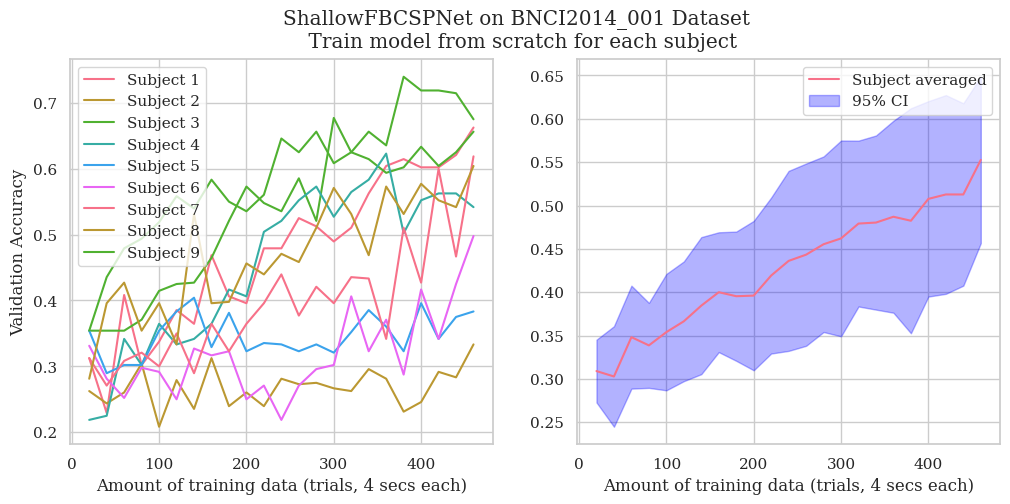

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

for subj_id, subj_res in dict_results.items():
    ax1.plot(subj_res.keys(), subj_res.values(), label=f'Subject {subj_id}')

ax1.legend()
ax1.set_xlabel('Amount of training data (trials, 4 secs each)')
ax1.set_ylabel('Validation Accuracy')

ax2.plot(subject_averaged_df, label='Subject averaged')
ax2.fill_between(subject_averaged_df.index, conf_interval_df[0], conf_interval_df[1], color='b', alpha=0.3, label='95% CI')
ax2.legend()
ax2.set_xlabel('Amount of training data (trials, 4 secs each)')

plt.suptitle('ShallowFBCSPNet on BNCI2014_001 Dataset \n Train model from scratch for each subject')

# plt.savefig(f'{results_dir}//{file_name}.png')